In [6]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline
warnings.filterwarnings('ignore')


In [9]:
train = pd.read_csv('/train.csv')
test = pd.read_csv('/test.csv')

# To know number of columns and rows
train.shape
# (891, 12)


(891, 12)

In [10]:
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [11]:
train.isnull().sum()


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

<Axes: ylabel='count'>

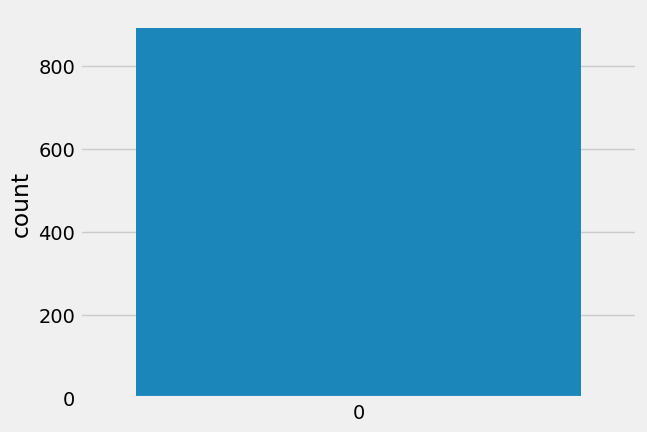

In [37]:
sns.countplot(train['Survived'])



In [20]:
# Create a new column cabinbool indicating
# if the cabin value was given or was NaN
train["CabinBool"] = (train["Cabin"].notnull().astype('int'))
test["CabinBool"] = (test["Cabin"].notnull().astype('int'))

# Delete the column 'Cabin' from test
# and train dataset
train = train.drop(['Cabin'], axis=1)
test = test.drop(['Cabin'], axis=1)


In [25]:
# sort the ages into logical categories
train["Age"] = train["Age"].fillna(-0.5)
test["Age"] = test["Age"].fillna(-0.5)
bins = [-1, 0, 5, 12, 18, 24, 35, 60, np.inf]
labels = ['Unknown', 'Baby', 'Child', 'Teenager',
		'Student', 'Young Adult', 'Adult', 'Senior']
train['AgeGroup'] = pd.cut(train["Age"], bins, labels=labels)
test['AgeGroup'] = pd.cut(test["Age"], bins, labels=labels)


In [26]:
# create a combined group of both datasets
combine = [train, test]

# extract a title for each Name in the
# train and test datasets
for dataset in combine:
	dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(train['Title'], train['Sex'])

# replace various titles with more common names
for dataset in combine:
	dataset['Title'] = dataset['Title'].replace(['Lady', 'Capt', 'Col',
												'Don', 'Dr', 'Major',
												'Rev', 'Jonkheer', 'Dona'],
												'Rare')

	dataset['Title'] = dataset['Title'].replace(
		['Countess', 'Lady', 'Sir'], 'Royal')
	dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
	dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
	dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

# map each of the title groups to a numerical value
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3,
				"Master": 4, "Royal": 5, "Rare": 6}
for dataset in combine:
	dataset['Title'] = dataset['Title'].map(title_mapping)
	dataset['Title'] = dataset['Title'].fillna(0)


In [27]:
mr_age = train[train["Title"] == 1]["AgeGroup"].mode() # Young Adult
miss_age = train[train["Title"] == 2]["AgeGroup"].mode() # Student
mrs_age = train[train["Title"] == 3]["AgeGroup"].mode() # Adult
master_age = train[train["Title"] == 4]["AgeGroup"].mode() # Baby
royal_age = train[train["Title"] == 5]["AgeGroup"].mode() # Adult
rare_age = train[train["Title"] == 6]["AgeGroup"].mode() # Adult

age_title_mapping = {1: "Young Adult", 2: "Student",
					3: "Adult", 4: "Baby", 5: "Adult", 6: "Adult"}

for x in range(len(train["AgeGroup"])):
	if train["AgeGroup"][x] == "Unknown":
		train["AgeGroup"][x] = age_title_mapping[train["Title"][x]]

for x in range(len(test["AgeGroup"])):
	if test["AgeGroup"][x] == "Unknown":
		test["AgeGroup"][x] = age_title_mapping[test["Title"][x]]


In [28]:
# map each Age value to a numerical value
age_mapping = {'Baby': 1, 'Child': 2, 'Teenager': 3,
			'Student': 4, 'Young Adult': 5, 'Adult': 6,
			'Senior': 7}
train['AgeGroup'] = train['AgeGroup'].map(age_mapping)
test['AgeGroup'] = test['AgeGroup'].map(age_mapping)

train.head()

# dropping the Age feature for now, might change
train = train.drop(['Age'], axis=1)
test = test.drop(['Age'], axis=1)


In [29]:
train = train.drop(['Name'], axis=1)
test = test.drop(['Name'], axis=1)


In [30]:
sex_mapping = {"male": 0, "female": 1}
train['Sex'] = train['Sex'].map(sex_mapping)
test['Sex'] = test['Sex'].map(sex_mapping)

embarked_mapping = {"S": 1, "C": 2, "Q": 3}
train['Embarked'] = train['Embarked'].map(embarked_mapping)
test['Embarked'] = test['Embarked'].map(embarked_mapping)


In [31]:
for x in range(len(test["Fare"])):
	if pd.isnull(test["Fare"][x]):
		pclass = test["Pclass"][x] # Pclass = 3
		test["Fare"][x] = round(
			train[train["Pclass"] == pclass]["Fare"].mean(), 4)

# map Fare values into groups of
# numerical values
train['FareBand'] = pd.qcut(train['Fare'], 4,
							labels=[1, 2, 3, 4])
test['FareBand'] = pd.qcut(test['Fare'], 4,
						labels=[1, 2, 3, 4])

# drop Fare values
train = train.drop(['Fare'], axis=1)
test = test.drop(['Fare'], axis=1)


In [32]:
from sklearn.model_selection import train_test_split

# Drop the Survived and PassengerId
# column from the trainset
predictors = train.drop(['Survived', 'PassengerId'], axis=1)
target = train["Survived"]
x_train, x_val, y_train, y_val = train_test_split(
	predictors, target, test_size=0.2, random_state=0)


In [42]:
sub = pd.read_csv('/content/gender_submission.csv')
sub.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [43]:
sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   PassengerId  418 non-null    int64
 1   Survived     418 non-null    int64
dtypes: int64(2)
memory usage: 6.7 KB


In [49]:
sub.to_csv('submission.csv', index=False)


In [53]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Load the Titanic dataset
data = pd.read_csv('/content/test.csv')
data = pd.read_csv('/content/train.csv')
# Preprocess the data
# Drop irrelevant features
data = data.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
# Handle missing values
data['Age'].fillna(data['Age'].median(), inplace=True)
data['Embarked'].fillna(data['Embarked'].mode()[0], inplace=True)
# Convert categorical variables into numerical
data['Sex'] = data['Sex'].map({'female': 0, 'male': 1})
data['Embarked'] = data['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})
# Split the data into features (X) and target (y)
X = data.drop('Survived', axis=1)
y = data['Survived']
# Split the data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Create an instance of the Random Forest Classifier
randomforest = RandomForestClassifier()

# Fit the training data along with its output
randomforest.fit(x_train, y_train)

# Predict the output labels for the validation data
y_pred = randomforest.predict(x_val)

# Find the accuracy score of the model
acc_randomforest = round(accuracy_score(y_pred, y_val) * 100, 2)
print("Accuracy:", acc_randomforest)


Accuracy: 81.01
